In [92]:
import re 
import tweepy 
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
nltk.download('punkt')   
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from tweepy import OAuthHandler 
from textblob import TextBlob 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [93]:
def connect():
  # Replace the xxxxx with your twitter api keys
  consumer_key = 'xxxxx'
  consumer_secret = 'xxxxx'
  access_token = 'xxxxx'
  access_token_secret = 'xxxxx'

  try:
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth)
    return api
  except:
    print("Error")
    exit(1)

In [94]:
def cleanText(text):
  text = text.lower()
  # Removes all mentions (@username) from the tweet since it is of no use to us
  text = re.sub(r'(@[A-Za-z0-9_]+)', '', text)
    
  # Removes any link in the text
  text = re.sub('http://\S+|https://\S+', '', text)

  # Only considers the part of the string with char between a to z or digits and whitespace characters
  # Basically removes punctuation
  text = re.sub(r'[^\w\s]', '', text)

  # Removes stop words that have no use in sentiment analysis 
  text_tokens = word_tokenize(text)
  text = [word for word in text_tokens if not word in stopwords.words()]

  text = ' '.join(text)
  return text

In [95]:
def stem(text):
  # This function is used to stem the given sentence
  porter = PorterStemmer()
  token_words = word_tokenize(text)
  stem_sentence = []
  for word in token_words:
    stem_sentence.append(porter.stem(word))
  return " ".join(stem_sentence)

In [96]:
def sentiment(cleaned_text):
  # Returns the sentiment based on the polarity of the input TextBlob object
  if cleaned_text.sentiment.polarity > 0:
    return 'positive'
  elif cleaned_text.sentiment.polarity < 0:
    return 'negative'
  else:
    return 'neutral'

In [97]:
def fetch_tweets(query, count = 50):
  api = connect() # Gets the tweepy API object
  tweets = [] # Empty list that stores all the tweets

  try:
    # Fetches the tweets using the api
    fetched_data = api.search(q = query + ' -filter:retweets', count = count)
    for tweet in fetched_data:
      txt = tweet.text
      clean_txt = cleanText(txt) # Cleans the tweet
      stem_txt = TextBlob(stem(clean_txt)) # Stems the tweet
      sent = sentiment(stem_txt) # Gets the sentiment from the tweet
      tweets.append((txt, clean_txt, sent))
    return tweets
  except tweepy.TweepError as e:
    print("Error : " + str(e))
    exit(1)



In [98]:
tweets = fetch_tweets(query = 'Hindi Language Imposition', count = 200)
# Converting the list into a pandas Dataframe
df = pd.DataFrame(tweets, columns= ['tweets', 'clean_tweets','sentiment'])

# Dropping the duplicate values just in case there are some tweets that are copied and then stores the data in a csv file
df = df.drop_duplicates(subset='clean_tweets')
df.to_csv('data.csv', index= False)

In [99]:
ptweets = df[df['sentiment'] == 'positive']
p_perc = 100 * len(ptweets)/len(tweets)
ntweets = df[df['sentiment'] == 'negative']
n_perc = 100 * len(ntweets)/len(tweets)
print(f'Positive tweets {p_perc} %')
print(f'Neutral tweets {100 - p_perc - n_perc} %')
print(f'Negative tweets {n_perc} %')

Positive tweets 9.210526315789474 %
Neutral tweets 71.05263157894737 %
Negative tweets 19.736842105263158 %


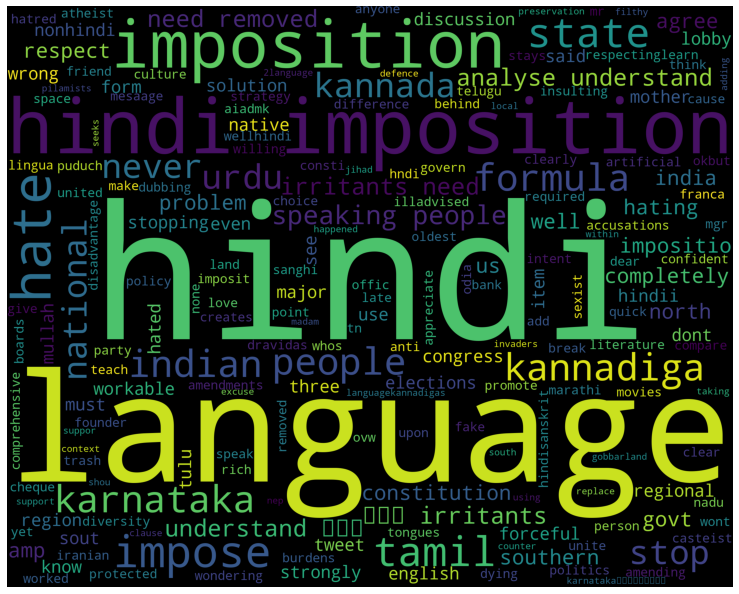

In [100]:
twt = " ".join(df['clean_tweets'])
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', width=2500, height=2000).generate(twt)

plt.figure(1,figsize=(13, 13))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()